In [1]:
import os
from dotenv import load_dotenv

# 加载 .env 文件中的环境变量
load_dotenv()

# 从环境变量中获取 API 密钥
STABILITY_API_KEY = os.getenv("STABILITY_API_KEY")

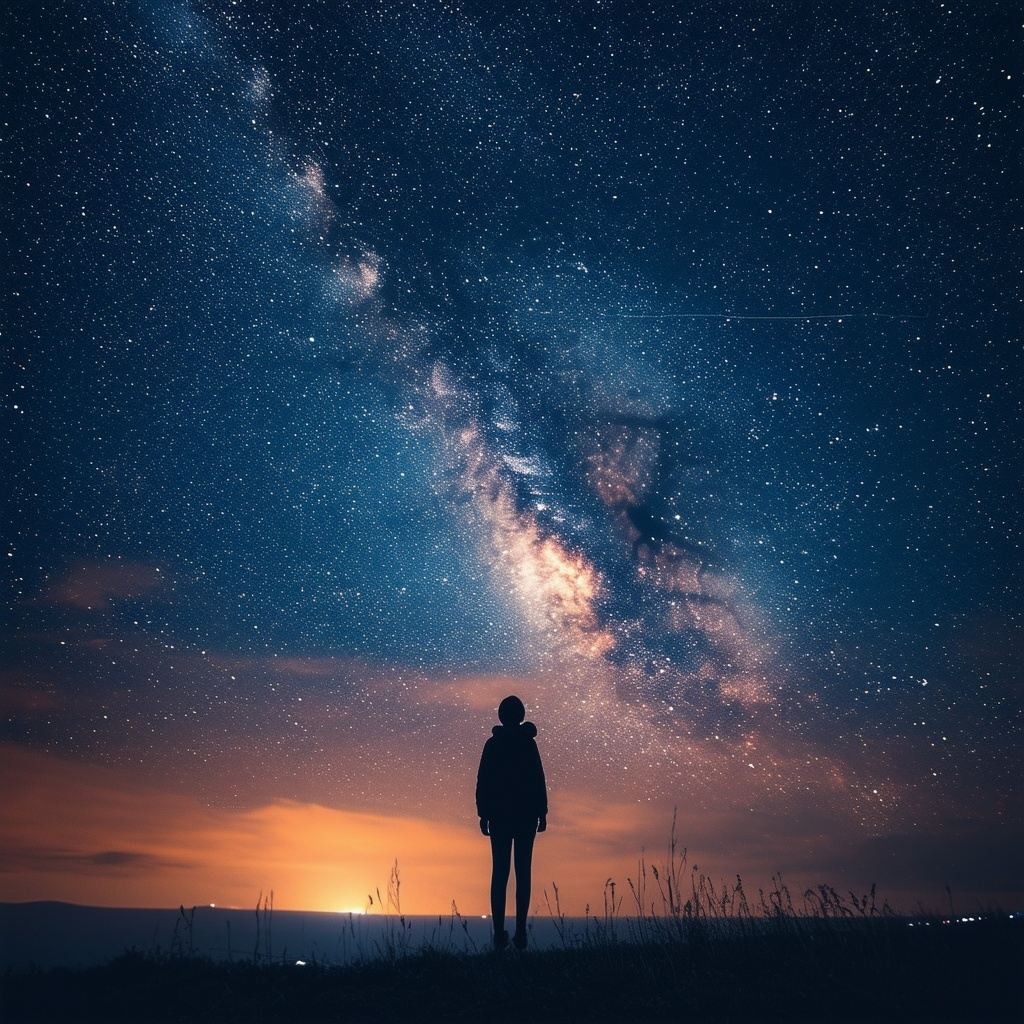

In [7]:
import requests
from IPython.display import Image

response = requests.post(
    f"https://api.stability.ai/v2beta/stable-image/generate/sd3",
    headers={
        "authorization": f"Bearer {STABILITY_API_KEY}",
        "accept": "image/*"
    },
    files={"none": ''},
    data={
        "prompt": "Looking up at the starry sky, humans are small, the universe is vast.",
        "output_format": "jpeg",
    },
)

if response.status_code == 200:
    display(Image(response.content))
else:
    print(f"Error: {response.status_code}")
    print(response.json())

In [8]:
if response.status_code == 200:
    with open("./humansmall.jpeg", 'wb') as file:
        file.write(response.content)
else:
    raise Exception(str(response.json()))

In [16]:
import requests
from PIL import Image
from pathlib import Path
from time import sleep

# 定义之前生成的图像文件路径
image_path = Path("./humansmall.jpeg")

# 检查图像文件是否存在
if image_path.exists():
    # 打开图像文件并调整尺寸
    with Image.open(image_path) as img:
        img = img.resize((1024, 576))  # 调整为1024x576的尺寸
        
        # 将调整后的图像保存到内存中
        from io import BytesIO
        buf = BytesIO()
        img.save(buf, format='JPEG')
        buf.seek(0)
        
        # 使用调整后的图像进行视频生成
        response = requests.post(
            f"https://api.stability.ai/v2beta/image-to-video",
            headers={
                "authorization": f"Bearer {STABILITY_API_KEY}"
            },
            files={
                "image": buf
            },
            data={
                "seed": 0,
                "cfg_scale": 1.8,
                "motion_bucket_id": 127
            },
        )
        
        # 检查API响应
        if response.status_code == 200:
            generation_id = response.json()['id']
            print(f"视频生成已启动,生成ID: {generation_id}")
            
            # 循环查询视频生成结果
            while True:
                response = requests.request(
                    "GET",
                    f"https://api.stability.ai/v2beta/image-to-video/result/{generation_id}",
                    headers={
                        'accept': "video/*",
                        'authorization': f"Bearer {STABILITY_API_KEY}"
                    },
                )
                
                if response.status_code == 202:
                    print("视频生成中,10秒后再次查询...")
                    sleep(10)
                elif response.status_code == 200:
                    print("视频生成完成!")
                    # 将生成的视频保存到本地文件
                    video_path = Path("./generated_video.mp4")
                    with open(video_path, 'wb') as file:
                        file.write(response.content)
                    break
                else:
                    raise Exception(str(response.json()))
        else:
            print(f"视频生成失败。错误信息: {response.json()}")
else:
    print(f"图像文件 {image_path} 不存在。请先生成并保存图像。")

视频生成已启动,生成ID: 352cc9b16d79e5fd8be8cfc00ff717d468ec298e470dd75a0a5878ee2fb04416
视频生成中,10秒后再次查询...
视频生成中,10秒后再次查询...
视频生成中,10秒后再次查询...
视频生成完成!
